## Data Preprocessing
---

* backfill later from iter 2

In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [ ]:
%time transactions_df = pd.read_parquet("../../data/joined/joined_1617834490/joined_1617834490.parquet")

existing_cols = transactions_df.columns

In [5]:
debug = False
sample = False
id_col = 'business_account_number'
id_token = "<BUSINESS_ACCOUNT_NUMBER>"
if debug:
    debug_ids = pd.read_csv('../../artifacts/debug_ids.csv')
    debug_ids[id_token] = debug_ids[id_token].astype(transactions_df[id_col].dtype)
    transactions_df = transactions_df[transactions_df[id_col].isin(debug_ids[id_token])]
    # load ids
    # filter by ids
# debug version: load and filter by debug_ids 
elif sample:
    transactions_df = transactions_df.sample(n=1000000, replace=False)

In [6]:
transactions_df.shape

(28260180, 109)

Timestamp('2021-04-07 01:27:37')

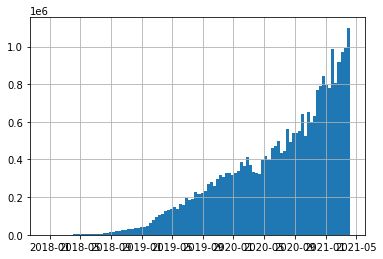

In [7]:
transactions_df.transaction_datetime.hist(bins=100)
transactions_df.transaction_datetime.max()

### Monthly transactions amounts:

In [8]:
df_ = transactions_df[transactions_df.transaction_datetime.between(pd.to_datetime("2020-08-01"),
                                                                   pd.to_datetime("2020-08-31"))]
df_.shape

(1221399, 109)

### Add ID
---

In [9]:
def get_transactions_id(transactions_df):
    transactions_df.sort_values(by=['business_account_number', 
                                    'transaction_datetime'],
                                inplace=True)
    transactions_df['group_rank'] = transactions_df.groupby('business_account_number')['transaction_datetime'].rank('first').astype(int)

    # get id by combining bid, datatime, and rank
    # actually need a way to order this key...
    transactions_df['transaction_id'] = (transactions_df['business_account_number'].astype(str) 
                                         + '-' + transactions_df['transaction_datetime'].apply(lambda x: str(int(x.timestamp())))
                                         + '-' + transactions_df['group_rank'].astype(str))
    return transactions_df

In [10]:
transactions_df = get_transactions_id(transactions_df)

transactions_df['transaction_id'].head()

0    410000007044-1513182391-1
1    410000007044-1513727720-2
2    410000007044-1513727720-3
3    410000007044-1513727720-4
4    410000007044-1513727720-5
Name: transaction_id, dtype: object

In [11]:
transactions_df['transaction_id'].nunique(), transactions_df.shape

(28260180, (28260180, 111))

### Move -f features over
---

In [12]:
# Sort data by transaction datetime.
transactions_df = transactions_df.sort_values(by=['business_account_number', 'transaction_datetime'])

### BANKING FEATURES
transactions_df = pd.merge(transactions_df, 
                  transactions_df.groupby('business_account_number')['transaction_datetime'].min()\
                  .rename('first_transaction_datetime').to_frame(), 
                  how='left', on='business_account_number')
transactions_df['days_since_first_deposit'] = (transactions_df['transaction_datetime'] - \
                                               transactions_df['first_transaction_datetime']).dt.days

transactions_df['age_money_account'] = (transactions_df['transaction_datetime'] - \
                                        transactions_df['odt']).dt.days

transactions_df['lag_acc_open_first_transaction'] = (transactions_df['first_transaction_datetime'] - \
                                                     transactions_df['odt']).dt.days

transactions_df['first_deposit_amount'] = transactions_df['afdep'] #TODO: this is a waste of space.

KeyError: 'odt'

In [ ]:
### CREDIT FEATURES
# No transformations on credit attributes at this time.
# Eventually will transform because of default values.

### GIACT FEATURES
transactions_df['giact_time_since_first_link'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['giact_first_link_date']).dt.days
transactions_df['giact_time_since_last_link'] = (transactions_df['transaction_datetime'] - \
                                                 transactions_df['giact_last_link_date']).dt.days

### TMX FEATURES
# Nothing at the moment.

In [ ]:
### External bank linkages:
res = []
curr = None
counter = {}

for row in tqdm(transactions_df[['business_account_number', 'transaction_datetime', 
                                 'external_account_number', 'external_institution_id', 
                                 'transaction_amount']].values):
    if row[0] != curr:
        curr = row[0]
        counter = {}

    if not row[2]:
        res.append([None for i in range(6)])
        continue

    out = []

    external_account_number = row[2]

    if external_account_number not in counter:
        counter[external_account_number] = {}

    # nr past transactions with this account
    if 'nr_trans_with_acc' in counter[external_account_number]:
        counter[external_account_number]['nr_trans_with_acc'] += 1
    else:
        counter[external_account_number]['nr_trans_with_acc'] = 1
    out.append(counter[external_account_number]['nr_trans_with_acc'] - 1)

    # first transaction dt
    if 'first_transaction_dt' not in counter[external_account_number]:
        counter[external_account_number]['first_transaction_dt'] = row[1]
    out.append(counter[external_account_number]['first_transaction_dt'])

    # last transaction_dt
    if 'last_transaction_dt' not in counter[external_account_number]:
        counter[external_account_number]['last_transaction_dt'] = None
    out.append(counter[external_account_number]['last_transaction_dt'])
    counter[external_account_number]['last_transaction_dt'] = row[1]

    # sum pos/neg transactions with acct
    if 'sum_pos_trans' not in counter[external_account_number]:
        counter[external_account_number]['sum_pos_trans'] = 0
    if 'sum_neg_trans' not in counter[external_account_number]:
        counter[external_account_number]['sum_neg_trans'] = 0
    out.append(counter[external_account_number]['sum_pos_trans'])
    out.append(counter[external_account_number]['sum_neg_trans'])

    if row[4] >= 0:
        counter[external_account_number]['sum_pos_trans'] += row[4]
    else:
        counter[external_account_number]['sum_neg_trans'] += row[4]

    if 'rolling_mean_pos_trans' not in counter[external_account_number]:
        counter[external_account_number]['rolling_mean_pos_trans'] = row[4]
        out.append(None)
    else:
        out.append(counter[external_account_number]['rolling_mean_pos_trans'])
        counter[external_account_number]['rolling_mean_pos_trans'] = (counter[external_account_number]['rolling_mean_pos_trans'] + row[4]) / 2

    res.append(out)

ea_cols = ['nr_trans_with_acc', 'first_trans_with_ea_dt', 'last_trans_with_ea_dt', 'sum_pos_trans_ea', 'sum_neg_trans_ea', 'rolling_mean_pos_trans_ea']
transactions_df = transactions_df.assign(**dict.fromkeys(ea_cols, np.nan))
transactions_df[ea_cols] = res

del res

In [ ]:
# ea -> external account
transactions_df['time_since_first_trans_ea'] = (transactions_df['transaction_datetime'] - transactions_df['first_trans_with_ea_dt']).dt.days
transactions_df['time_since_last_trans_ea'] = (transactions_df['transaction_datetime'] - transactions_df['last_trans_with_ea_dt']).dt.days

transactions_df['ratio_all_ea_trans_div_tamt'] = transactions_df['sum_pos_trans_ea'] / transactions_df['transaction_amount']
transactions_df['ratio_rolling_mean_ea_tamt_div_tamt'] = transactions_df['rolling_mean_pos_trans_ea'] / transactions_df['transaction_amount']


### TRANSACTION (not roll-ups) FEATURES
transactions_df['transaction_as_pct_of_balance'] = transactions_df['transaction_amount'] / \
                                                   (transactions_df['real_ending_balance'] - \
                                                    transactions_df['transaction_amount'])

transactions_df['last_transaction_datetime'] = transactions_df.groupby('business_account_number')['transaction_datetime'].shift(1)
# transactions_df['last_transaction_code'] = transactions_df.groupby('business_account_number')['transaction_code'].shift(1)

transactions_df['time_since_last_transaction'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['last_transaction_datetime']).dt.seconds # this relies on transactions we don't like not being included!

### Transaction Features

#### Multithreading workshop

In [ ]:
from multiprocessing import Pool, cpu_count

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [ ]:
# script manufactory
def remove_breakers(s):
    return "".join("".join(s.split("\n")).split(" "))

def get_kw_idx(L, kw):
    for i, s in enumerate(L):
        if s.startswith(kw):
            return i
    return -1

def parallel_formatter(s, print_fn=True):
    """
    works for the format:
    df[] = df.groupby()[].func().values
    
    seems like functions that will benefit includes:
    - rolling
    - maybe expanding?
    
    doesnot work for cumcount - attribute of groupby
    """
    # assert(check_format(s))
    
    s = remove_breakers(s).split(".")
    
    # get components
    groupby_idx = get_kw_idx(s, "groupby")
    values_idx = get_kw_idx(s, "values")
    
    # get func str parts
    func_parts = s[groupby_idx+1:values_idx]
    func_str = f"""def func(df_): return df_.{'.'.join(func_parts)}"""
    
    # get apply str parts
    str_left = ".".join(s[:groupby_idx+1])
    setter_str, groupby_str = str_left.split("=")
    apply_str = f"""{setter_str}=applyParallel({groupby_str}, func).values"""
    
    result = "\n".join([func_str, apply_str])
    if print_fn:
        print(result)
    else:
        return result
    
s = """                                                         
transactions_df['nr_transactions_3h'] = transactions_df.groupby('business_account_number') \
    .rolling('3h', min_periods=1, on='transaction_datetime')['is_trans'].sum().values
|||
transactions_df['nr_deposits_3h'] = transactions_df.groupby('business_account_number') \
    .rolling('3h', min_periods=1, on='transaction_datetime')['is_deposit'].sum().values

"""

# S = [s]
S = s.split("|||")
for s in S:
    parallel_formatter(s)

In [ ]:
# e.g.
s = """transactions_df['nr_returns_30d'] = transactions_df.groupby('business_account_number') \
                                                   .rolling('30d', min_periods=1, \
                                                            on='transaction_datetime') \
                                                    ['is_return'].sum().values"""
parallel_formatter(s)

In [ ]:
# transactions_df['nr_past_returns_'] = transactions_df.groupby('business_account_number')['is_return'].cumsum().values
# def func(df_): return df_.cumsum()

# transactions_df['nr_past_returns']=applyParallel(transactions_df.groupby('business_account_number')['is_return'], func).values

## To parallelize:

In [ ]:
%%time
# # transaction features
deposit_transaction_codes = ['POSDD', 'ACHDD', 'ACHDDIN', 'ACHINDD', 'DDCK', 'DDMBR', 'DD']
withdrawal_transaction_codes = ['POSDW', 'ACHDW', 'ACHDWIN', 'DWATM', 'DWATMI', 'DWCK', 'DWBILLPAY',
                                'DWCRDBILLPAY', 'DWMBR', 'ACHDWP2P', 'DWWIRE', 'DBDWWIRE', 'DWTRF', 'DBDW', 'DWSLROTP', 'DW']

transactions_df['is_return'] = (transactions_df['transaction_code'].isin(['DWCKCB', 'DWACHRET', 'DDACHRET']) | \
                                      ((transactions_df['transaction_code'].isin(deposit_transaction_codes)) & \
                                       (transactions_df['transaction_amount'] < 0)))
transactions_df['is_trans'] = transactions_df['transaction_code'].isin(deposit_transaction_codes + withdrawal_transaction_codes)
transactions_df['is_deposit'] = transactions_df['transaction_code'].isin(deposit_transaction_codes) & \
                                (transactions_df['transaction_amount'] > 0)


In [ ]:
transactions_df['nr_past_returns'] = transactions_df.groupby('business_account_number')['is_return'].cumsum()

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['is_return'].sum()
transactions_df['nr_returns_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['nr_past_deposits'] = transactions_df.groupby('business_account_number')['is_deposit'].cumsum()

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

In [ ]:
%%time

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['pct_returned_deposits'] = transactions_df['nr_past_returns'] / \
                                           transactions_df['nr_past_deposits']

transactions_df['pct_returned_deposits_30d'] = transactions_df['nr_returns_30d'] / \
                                               transactions_df['nr_deposits_30d']

In [ ]:
%%time
# features cannot be parallelized that may take a while
transactions_df['nr_past_transactions'] = transactions_df.groupby('business_account_number')['business_account_number'].cumcount()

In [ ]:
%%time

transactions_df['nr_transactions_30d_div_nr_past_transactions'] = transactions_df['nr_transactions_30d'] / transactions_df['nr_past_transactions']

transactions_df['tamt_adjusted'] = transactions_df['transaction_amount'] * np.where(transactions_df['transaction_code'] == 'ACHDD', -1, 1)

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['mean_account_balance_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['mean_account_balance_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

# def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['real_ending_balance'].std()
# transactions_df['std_account_balance_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

# def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['real_ending_balance'].std()
# transactions_df['std_account_balance_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

In [ ]:
%%time

transactions_df['deposit_transaction_amount'] = (transactions_df['is_deposit'] * transactions_df['transaction_amount']).replace(np.nan, 0)

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].sum()
transactions_df['sum_deposits_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].sum()
transactions_df['sum_deposits_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].sum()
transactions_df['sum_deposits_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values


transactions_df['is_withdrawal'] = transactions_df['transaction_code'].isin(withdrawal_transaction_codes) & \
                                   (transactions_df['transaction_amount'] < 0)
transactions_df['withdrawal_transaction_amount'] = (transactions_df['is_withdrawal'] * transactions_df['transaction_amount']).replace(np.nan, 0)

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].sum()
transactions_df['sum_withdrawals_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].sum()
transactions_df['sum_withdrawals_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].sum()
transactions_df['sum_withdrawals_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

In [ ]:
%%time 

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].mean()
transactions_df['mean_deposits_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.expanding().mean()
transactions_df['mean_deposits']=applyParallel(transactions_df.groupby('business_account_number')['deposit_transaction_amount'], func).values

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].mean()
transactions_df['mean_withdrawals_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.expanding().mean()
transactions_df['mean_withdrawals']=applyParallel(transactions_df.groupby('business_account_number')['withdrawal_transaction_amount'], func).values

transactions_df['mean_deposits_10d_div_mean_deposits'] = transactions_df['mean_deposits_10d'] / transactions_df['mean_deposits']
transactions_df['mean_withdrawals_10d_div_mean_withdrawals'] = transactions_df['mean_withdrawals_10d'] / transactions_df['mean_withdrawals']

In [ ]:
%%time

def func(df_): return df_.expanding().max()
transactions_df['max_deposits']=applyParallel(transactions_df.groupby('business_account_number')['deposit_transaction_amount'], func).values

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].max()
transactions_df['max_deposits_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].max()
transactions_df['max_deposits_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.expanding().max()
transactions_df['max_withdrawals']=applyParallel(transactions_df.groupby('business_account_number')['withdrawal_transaction_amount'], func).values

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].min()
transactions_df['max_withdrawals_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].min()
transactions_df['max_withdrawals_10d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['max_deposits_10d_div_mean_deposits'] = transactions_df['max_deposits_10d'] / transactions_df['mean_deposits']
transactions_df['max_deposits_10d_div_mean_account_balance_30d'] = transactions_df['max_deposits_10d'] / transactions_df['mean_account_balance_30d']
transactions_df['max_withdrawals_10d_div_mean_withdrawals'] = transactions_df['max_withdrawals_10d'] / transactions_df['mean_withdrawals']

In [ ]:
%%time 

transactions_df['nr_trans_ratio'] = transactions_df['nr_transactions_3d'] / transactions_df['nr_transactions_30d']
transactions_df['bal_ratio'] = transactions_df['mean_account_balance_3d'] / transactions_df['mean_account_balance_30d']
transactions_df['deposits_ratio'] = transactions_df['sum_deposits_3d'] / transactions_df['sum_deposits_30d']

transactions_df['is_dd'] = transactions_df['transaction_code'] == 'ACHINDD'
transactions_df['dd_dollar_amount'] = transactions_df['is_dd'] * transactions_df['transaction_amount']

transactions_df['nr_direct_deposits'] = transactions_df.groupby('business_account_number')['is_dd'].cumsum()
transactions_df['dollar_val_dd'] = transactions_df.groupby('business_account_number')['dd_dollar_amount'].cumsum()


In [ ]:
%%time

################################################
#      DEPOSIT V1 features for bencharking: 
################################################
def func(df_): return df_.rolling('14d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['rolling_mean_acc_bal']=applyParallel(transactions_df.groupby('business_account_number'), func).values

# nr_transactions_per_day
transactions_df['nr_past_transactions'] = transactions_df.groupby('business_account_number')\
                                            ['business_account_number'].cumcount()
transactions_df['nr_transactions_per_day'] = transactions_df['nr_past_transactions'] / \
                                             transactions_df['days_since_first_deposit']

# transaction_as_pct_of_balance
transactions_df['transaction_as_pct_of_balance'] = transactions_df['transaction_amount'] / \
                                                   (transactions_df['real_ending_balance'] - \
                                                    transactions_df['transaction_amount'])

# rolling_trns_as_pct_of_bal
transactions_df['transaction_as_pct_of_balance_abs'] = transactions_df['transaction_as_pct_of_balance'].abs()

def func(df_): return df_.rolling('7d',min_periods=1,on='transaction_datetime')['transaction_as_pct_of_balance_abs'].mean()
transactions_df['rolling_trns_as_pct_of_bal']=applyParallel(transactions_df.groupby('business_account_number'), func).values

# transaction_as_pct_of_bal_min
def func(df_): return df_.rolling('7d',min_periods=1,on='transaction_datetime')['transaction_as_pct_of_balance'].min()
transactions_df['transaction_as_pct_of_bal_min']=applyParallel(transactions_df.groupby('business_account_number'), func).values

# rolling_mean_acc_bal <<< THIS IS WRONG? something going wrong!!
def func(df_): return df_.rolling('14d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['rolling_mean_acc_bal']=applyParallel(transactions_df.groupby('business_account_number'), func).values

In [ ]:
%%time 
####################################################################
#    FEATURES FOR LABELING and DEBUGGING - has data snooping bias
####################################################################
transactions_df = pd.merge(transactions_df, 
                           transactions_df.groupby('business_account_number')['business_account_number'].count().rename('nr_transactions_all_time').reset_index(),
                           how='inner',
                           on='business_account_number')

transactions_df = pd.merge(transactions_df, 
                           transactions_df[transactions_df['is_return']].groupby('business_account_number')['transaction_datetime'].min().rename('first_return_date').reset_index(),
                           how='left',
                           on='business_account_number')

transactions_df = pd.merge(transactions_df, 
                           transactions_df[transactions_df['transaction_code'].isin(['DDCHGOFF', 'DDWRTOFF', 'DDFRDWO'])].groupby('business_account_number')['transaction_datetime'].min().rename('chg_wrt_off_date').reset_index(),
                           how='left',
                           on='business_account_number')

transactions_df = pd.merge(transactions_df, 
                           transactions_df.groupby('business_account_number')['is_return'].sum().rename('nr_returns_all_time').reset_index(),
                           how='inner',
                           on='business_account_number')

### Add some more features
---

#### Shared by both ACH and MCD

In [ ]:
%%time 

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['withdrawal_transaction_amount'].min()
transactions_df['max_withdrawals_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['deposit_transaction_amount'].max()
transactions_df['max_deposits_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['return_dollar_amount'] = transactions_df['is_return'] * transactions_df['tamt_adjusted']
transactions_df['dollar_val_returns'] = transactions_df.groupby('business_account_number')['return_dollar_amount'].cumsum()

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['return_dollar_amount'].sum()
transactions_df['dollar_val_returns_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['plaid_days_since_first_link'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['plaid_first_link_date']).dt.days
# transactions_df['quovo_days_since_first_link'] = (transactions_df['transaction_datetime'] - \
#                                                   transactions_df['quovo_first_link_date']).dt.days

In [ ]:
transactions_df['nr_days_to_chg_wrt_off'] = (transactions_df['chg_wrt_off_date'] - 
                                             transactions_df['transaction_datetime']).dt.days
df_w_chg_off = transactions_df[~transactions_df.nr_days_to_chg_wrt_off.isna()]
df_w_chg_off.nr_days_to_chg_wrt_off.hist(bins=100)

#### From MCD final push

In [ ]:
deposit_transaction_codes = ['POSDD', 'ACHDD', 'ACHDDIN', 'ACHINDD', 'DDCK', 'DDMBR', 'DD']
withdrawal_transaction_codes = ['POSDW', 'ACHDW', 'ACHDWIN', 'DWATM', 'DWATMI', 'DWCK', 'DWBILLPAY',
                                'DWCRDBILLPAY', 'DWMBR', 'ACHDWP2P', 'DWWIRE', 'DBDWWIRE', 'DWTRF', 'DBDW', 'DWSLROTP', 'DW']


In [ ]:
transactions_df.sort_values(by=['business_account_number', 'transaction_datetime'], inplace=True)

In [ ]:
## Test out expanding too

In [ ]:
# transactions_df['deposit_transaction_amount'] = (transactions_df['is_deposit'] * transactions_df['transaction_amount']).replace(np.nan, 0)

# %time transactions_df['max_deposits'] = transactions_df.groupby('business_account_number')['deposit_transaction_amount'].expanding().max().values

# def func(df_): return df_.expanding().max()
# %time transactions_df['max_deposits_']=applyParallel(transactions_df.groupby('business_account_number')['deposit_transaction_amount'], func).values

In [ ]:
# from sklearn.metrics import mean_absolute_error as mse

# mse(transactions_df["max_deposits"], transactions_df["max_deposits_"])

In [ ]:
# transactions_df[transactions_df["nr_past_returns_ach"]>0]["nr_past_returns_ach"].hist(bins=100, alpha=0.5)
# transactions_df[transactions_df["nr_past_returns_ach_"]>0]["nr_past_returns_ach_"].hist(bins=100, alpha=0.5)

In [ ]:
# number of different types of returns
transactions_df['is_return_ach'] = transactions_df['transaction_code'].isin(['DWACHRET', 'DDACHRET'])
transactions_df['is_return_mcd'] = transactions_df['transaction_code'].isin(['DWCKCB'])
transactions_df['is_return_other'] = ((transactions_df['transaction_code'].isin(deposit_transaction_codes)) & \
                                       (transactions_df['transaction_amount'] < 0))

# nr_past_return_types
transactions_df['nr_past_returns_ach'] = transactions_df.groupby('business_account_number')['is_return_ach'].cumsum().values
transactions_df['nr_past_returns_mcd'] = transactions_df.groupby('business_account_number')['is_return_mcd'].cumsum().values
transactions_df['nr_past_returns_other'] = transactions_df.groupby('business_account_number')['is_return_other'].cumsum().values

In [ ]:
%%time
# nr_returns_nd
def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_return'].sum()
transactions_df['nr_returns_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_return_ach'].sum()
transactions_df['nr_returns_ach_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_return_mcd'].sum()
transactions_df['nr_returns_mcd_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

In [ ]:
%%time
# bouncing streaks
deposit_transaction_codes = ['POSDD', 'ACHDD', 'ACHDDIN', 'ACHINDD', 'DDCK', 'DDMBR', 'DD']

condition = (transactions_df['transaction_code'].isin(deposit_transaction_codes) |
             transactions_df['is_return'])
df_temp = transactions_df[condition][['transaction_id', 
                                      'business_account_number', 
                                      'transaction_datetime',
                                      'is_return']]
df_temp.sort_values(['business_account_number', 'transaction_datetime'], inplace=True)
# out of past 5 deposit related transactions, how many were returns
def func(df_): return df_.rolling(5,min_periods=1)['is_return'].mean()
df_temp['rolling_deposit_returns']=applyParallel(df_temp.groupby('business_account_number'), func).values

transactions_df = pd.merge(transactions_df, df_temp[['transaction_id', 'rolling_deposit_returns']], 
                           how='left', on='transaction_id')
transactions_df['rolling_deposit_returns'].fillna(0, inplace=True)

In [ ]:
# multiple small deposits then a big one

s = transactions_df['deposit_transaction_amount']
transactions_df[s.between(1,s.quantile(0.95))]['deposit_transaction_amount'].hist(bins=100)

In [ ]:
condition = transactions_df['deposit_transaction_amount'] > 0
meta_cols = ['transaction_id', 
             'business_account_number', 
             'transaction_datetime',
             'deposit_transaction_amount']
df_temp = transactions_df[condition][meta_cols]

In [ ]:
%%time
# captures small, small, large pattern
def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_3']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_5']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_10']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_3']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_5']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_10']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_3']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_5']=applyParallel(df_temp.groupby('business_account_number'), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_10']=applyParallel(df_temp.groupby('business_account_number'), func).values


df_temp['deposits_trend_short1'] = df_temp['max_deposits_last_3'] - df_temp['median_deposits_last_5']
df_temp['deposits_trend_ratio_short1'] = df_temp['max_deposits_last_3'] / df_temp['median_deposits_last_5']
df_temp['deposits_trend_mid1'] = df_temp['max_deposits_last_3'] - df_temp['median_deposits_last_10']
df_temp['deposits_trend_ratio_mid1'] = df_temp['max_deposits_last_3'] / df_temp['median_deposits_last_10']
df_temp['deposits_trend_mid2'] = df_temp['mean_deposits_last_3'] - df_temp['median_deposits_last_10']
df_temp['deposits_trend_ratio_mid2'] = df_temp['mean_deposits_last_3'] / df_temp['median_deposits_last_10']

new_cols = [f for f in df_temp.columns if f not in meta_cols]

In [ ]:
transactions_df = pd.merge(transactions_df, df_temp[new_cols+['transaction_id']], 
                           how='left', on='transaction_id')
transactions_df[new_cols].fillna(0, inplace=True)

In [ ]:
# nr_deposits, nr_transactions over a period; and their ratios

def func(df_): return df_.rolling('24h',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_1d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('24h',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_1d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['nr_deposits_ratio_1d'] = transactions_df['nr_deposits_1d'] / transactions_df['nr_transactions_1d']

def func(df_): return df_.rolling('3h',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_3h']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('3h',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_3h']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['nr_deposits_ratio_3h'] = transactions_df['nr_deposits_3h'] / transactions_df['nr_transactions_3h']

In [ ]:
s = transactions_df['nr_deposits_3h'] 
s.hist(bins=100)
plt.show()
transactions_df[s.between(s.quantile(0.01), s.quantile(0.99))]['nr_transactions_1d'].hist(bins=100)
plt.show()

In [ ]:
new_features = [f for f in transactions_df.columns if f not in existing_cols]
new_features

In [ ]:
transactions_df.to_parquet('../../artifacts/final/transactions_df_w_new_features.parquet')

### Get ACH_labels
---

In [ ]:
from tqdm import tqdm 
from pandas.tseries.offsets import BDay
from multiprocessing import Pool, cpu_count


### Helper functions
def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

## Need to define forward looking roll-ups at top level to parallelize.

# df['nr_returns_in_next_5d'] = applyParallel(df[['business_account_number', 
#                                                 'is_return']].groupby('business_account_number'), 
#                                             get_nr_returns_5d).values

def get_nr_returns_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['is_return'].sum())

def get_bal_after_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['real_ending_balance'].apply(lambda a: a[0], raw=True))

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

def stupid_hack(x):
    try:
        return x[-1]
    except:
        return x


def match_ach_returns(df, timedelta=BDay(3)):
    """
    Check if ACH transactions are returned with some timeframe.
    """
    #For performance purposes...
    df = df[df['transaction_code'].isin(['ACHDD', 'DWACHRET'])]
    
    # df = df.reset_index(drop=True)

    df['tamt_abs'] = df['transaction_amount'].abs()
    df['is_returned'] = False
    
    for act_n, transaction in tqdm(df[df['is_return'] == 1].iterrows()):
        
        tdt_hi = transaction['transaction_datetime']
        tdt_lo = tdt_hi - timedelta

        dcandidate = df[df['business_account_number'] == transaction['business_account_number']]

        dret = dcandidate[(dcandidate['transaction_datetime'].between(tdt_lo, tdt_hi)) & \
                          (dcandidate['tamt_abs'] == transaction['tamt_abs'])]
        
        df.loc[dret.index, 'is_returned'] = True

#     df = df.reset_index(drop=True)
    return df

def get_labels(df):
    """
    Get add labels to processed data.
    """    
    # sort data for roll-ups
    df = df.sort_values(by=['business_account_number', 'transaction_datetime'])

    df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df['account_closed_by_risk_in_next_90d'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= 90)
    
    # does account chg/wrt off in next 90 days?
    df['is_chg_wrt_off_in_90d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= 90

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    # get num returns by borrower in the next 90 days
    df['nr_returns_in_next_5d'] = applyParallel(df[['business_account_number', 'is_return']].groupby('business_account_number'), get_nr_returns_5d).values
    
    # get this borrower's account balance after 90 days
    df['bal_after_5d'] = applyParallel(df[['business_account_number', 'real_ending_balance']].groupby('business_account_number'), get_bal_after_5d).values

    df = df.reset_index()
    
    if 'level_0' in df.columns:
        df = df.drop('level_0', axis=1)
    
    return df  


# drop non ACH types
def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

In [ ]:
cols = """
business_account_number
transaction_datetime
dtc
closed_reason
chg_wrt_off_date
is_return
real_ending_balance
transaction_code
transaction_amount
""".split()

In [ ]:
# getting features that will be used for labels
%time transactions_df_ = get_labels(transactions_df[cols])
transactions_df_.columns

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# match ach returns to get is_returned
%time transactions_df__ = match_ach_returns(transactions_df_)

In [ ]:
transactions_df.shape, transactions_df_.shape, transactions_df__.shape

In [ ]:
transactions_df.index.max(), transactions_df_.index.max(), transactions_df__.index.max()

In [ ]:
def combine_df_by_idx(df1, df2):
    for col in df2.columns:
        idx = df2.index
        if col in df1.columns:
            print(f"column {col} equals? {df1.loc[idx, col].equals(df2[col])}")
        else:
            print(f"adding column {col}")
            df1[col] = np.nan
            df1.loc[idx, col] = df2[col]
    return df1

In [ ]:
# join labeled dfs with 
transactions_df = combine_df_by_idx(transactions_df, transactions_df_)
transactions_df = combine_df_by_idx(transactions_df, transactions_df__)

In [ ]:
# output as unlabeled...
transactions_df.to_parquet('../../artifacts/final/transactions_df_labeled_ach.parquet')

### Add MCD label
---

In [ ]:
from pandas.tseries.offsets import BDay
from tqdm import tqdm

def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

NDAYS = 90

def get_nr_returns_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['is_return'].sum())

def get_bal_after_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['real_ending_balance'].apply(lambda a: a[0], raw=True))

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [ ]:
from multiprocessing import Pool, cpu_count

def get_labels_nd(df, n_days=90):
    """
    Get add labels to processed data.
    """
    # sort data for roll-ups
    global NDAYS
    NDAYS = n_days
    print(f'Ndays = {NDAYS}')
    
    # sort data for roll-ups
    
        

#     df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df[f'account_closed_by_risk_in_next_{n_days}d'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= n_days)
    
#     df['last_unrestricted_date_in_next_90d'] = (df['last_unrestricted_date'] - df['transaction_datetime']).dt.days.between(0, 90)
    
    # get most recent account balance
    df = pd.merge(df, 
                  df.groupby('business_account_number')['real_ending_balance'].last().rename('latest_acc_bal').reset_index(),
                  how='left', on='business_account_number')

    # does account chg/wrt off in next n days?
    df[f'is_chg_wrt_off_in_{n_days}d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= n_days

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    df[f'bal_after_{n_days}d'] = applyParallel(df[['business_account_number', 
                                           'real_ending_balance']].groupby('business_account_number'), 
                                                     get_bal_after_nd).values
    df[f'nr_returns_in_next_{n_days}d'] = applyParallel(df[['business_account_number', 
                                                    'is_return']].groupby('business_account_number'), 
                                                 get_nr_returns_nd).values
    df = df.reset_index()
                
    # drop non check types
    
    
    def get_target(df):
        """
        """
        df[f'target_{n_days}d'] = df[f'is_chg_wrt_off_in_{n_days}d'] | \
                       df[f'account_closed_by_risk_in_next_{n_days}d'] | \
                       (df[f'nr_returns_in_next_{n_days}d'] > 0) | \
                       (df[f'bal_after_{n_days}d'] < 0)
        
        df[f'indeterminate_{n_days}d'] = (df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] > 0)) | \
                              (~df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] <= 0))
        
        return df

    df = get_target(df)

    return df #.reset_index()


In [ ]:
def sort_dfs(df):
    df.sort_values(by=['business_account_number', 'transaction_datetime', 'transaction_amount'], inplace=True)

def drop_non_check(df):
    df = df[df['transaction_code'].isin(['DDCK']) & (df['transaction_amount'] > 0)]
    return df

In [ ]:
sort_dfs(transactions_df)

for n in tqdm([10, 30, 60]):
    transactions_df = get_labels_nd(transactions_df, n_days=n)

In [ ]:
transactions_df.columns[transactions_df.columns.str.contains('target')]

In [ ]:
transactions_df.to_parquet('../../artifacts/final/transactions_df_labeled_all.parquet')

In [ ]:
new_cols = [f for f in transactions_df.columns if f not in existing_cols]
len(new_cols), new_cols[:10]

### Load things back..

In [ ]:
transactions_df = pd.read_parquet("../../artifacts/final/transactions_df_labeled_all.parquet")

In [ ]:
transactions_df.shape

In [ ]:
transactions_df['time_since_last_transaction'].hist(bins=100)